In [1]:
import tensorflow as tf
import loadData
import model
import numpy as np
import glob, sys
import matplotlib.pyplot as plt
import tqdm 
%matplotlib inline

sys.path.append("/home/msmith/misc/py/")
sys.path.append("/home/msmith/misc/tfFunctions/")

from dice import dice
from performance import performance
from hStackBatch import hStackBatch
from IPython.display import clear_output

def showBatch(x,y,yPred,unnormalize=1):
    x, y, yPred = [hStackBatch(im) for im in [x,y,yPred]]
    if unnormalize == 1:
        x *= 255
        y *= 255
        yPred *= 255

    x,y,yPred = [im.astype(np.uint8).squeeze()[:,:,::-1] for im in [x,y,yPred]]
    print("*"*100)
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.imshow(x)
    plt.subplot(312)
    plt.imshow(np.vstack((y,yPred)))
    plt.show()

def mse(y,yPred):
	return tf.reduce_mean(tf.square(tf.sub(y,yPred)))

def trainer(loss,learningRate,momentum=0.9):
    return tf.train.AdamOptimizer(learningRate).minimize(loss)



Using TensorFlow backend.


Model dims
('Layer 1 = ', [None, 600, 900, 3])
('Layer 2 = ', [None, 300, 450, 32])
('Layer 3 = ', [None, 150, 225, 64])
('Layer 4 = ', [None, 75, 113, 96])
('Layer 5 = ', [None, 38, 57, 128])
('Layer 6 = ', [None, 38, 57, 3])
('Layer 7 = ', [None, 38, 57, 3])
EPOCH 0 of 1
0.01
****************************************************************************************************


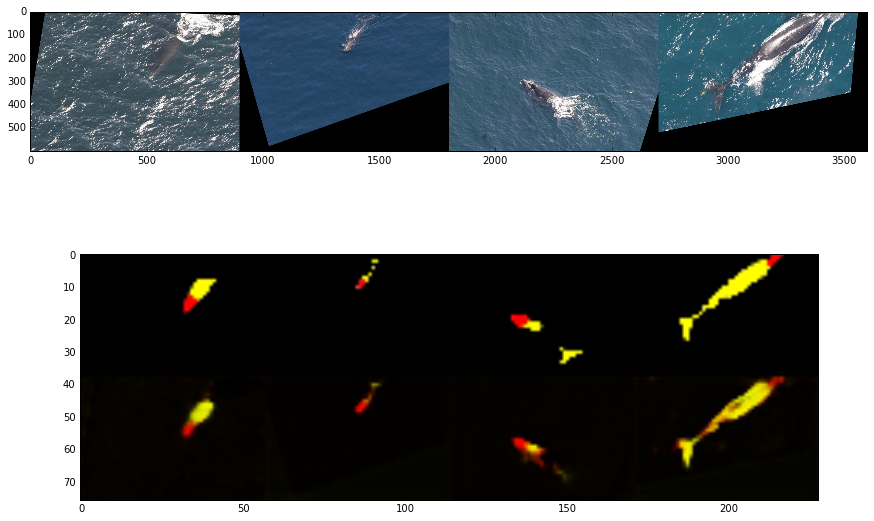

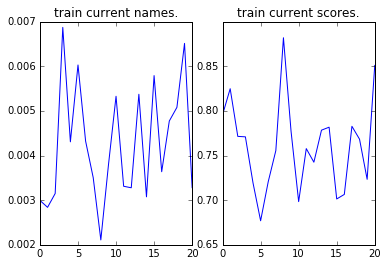

****************************************************************************************************


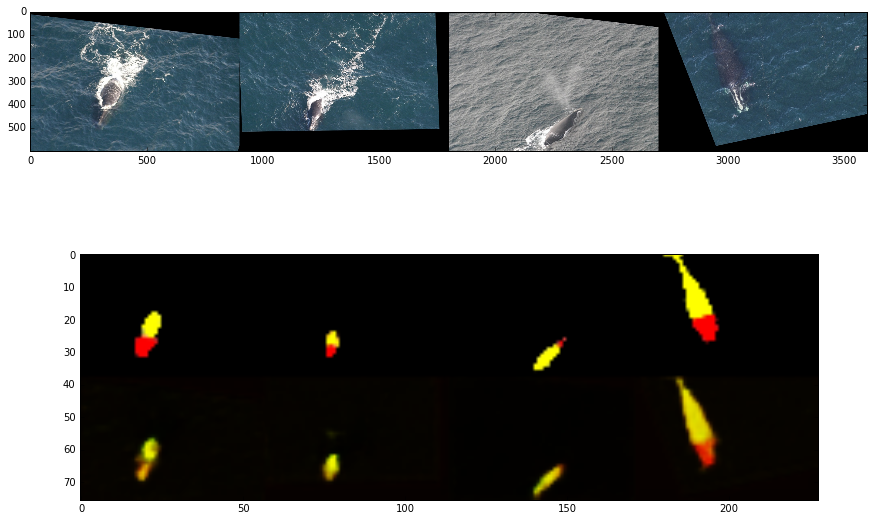

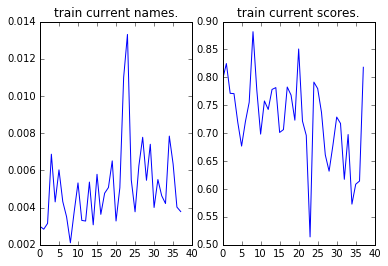

****************************************************************************************************


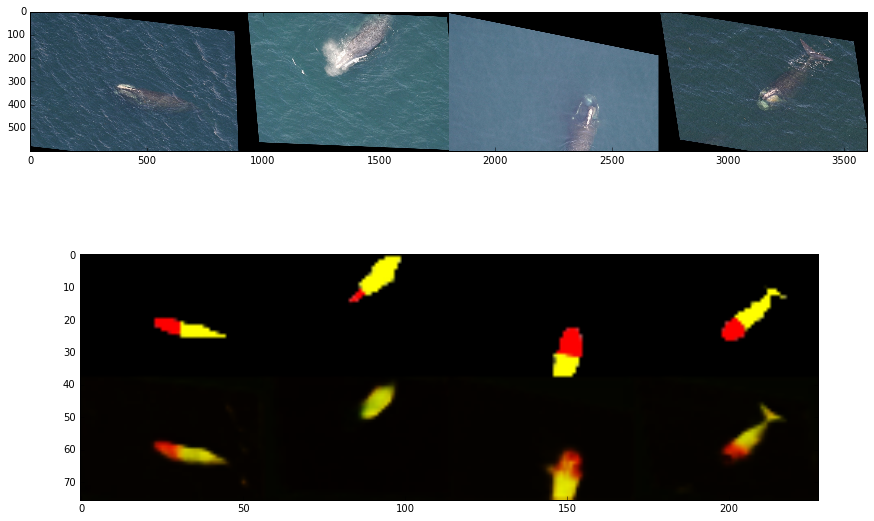

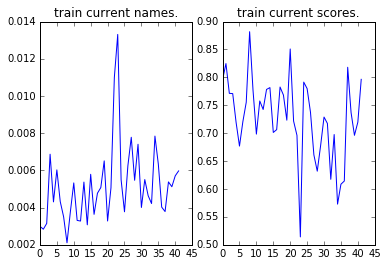

****************************************************************************************************


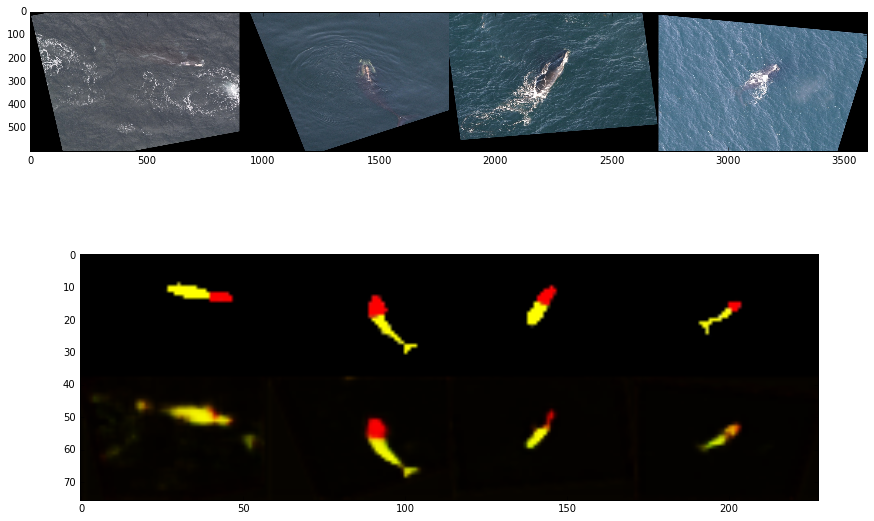

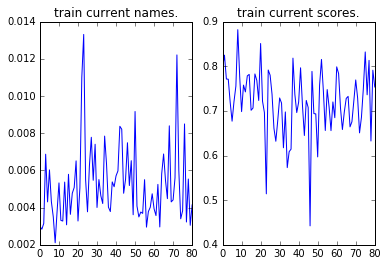

****************************************************************************************************


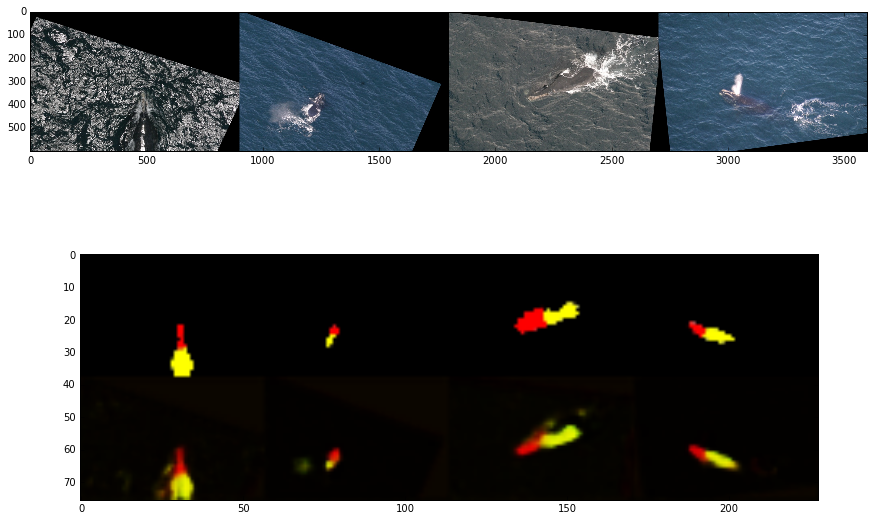

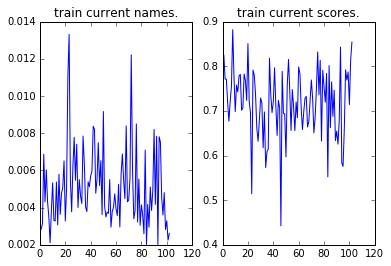

****************************************************************************************************


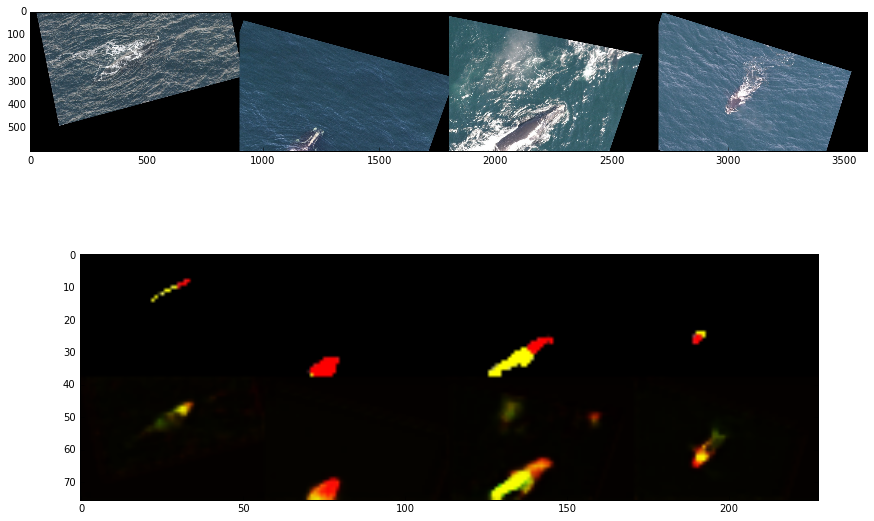

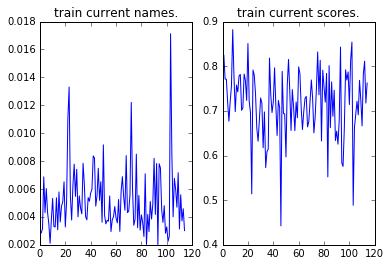

****************************************************************************************************


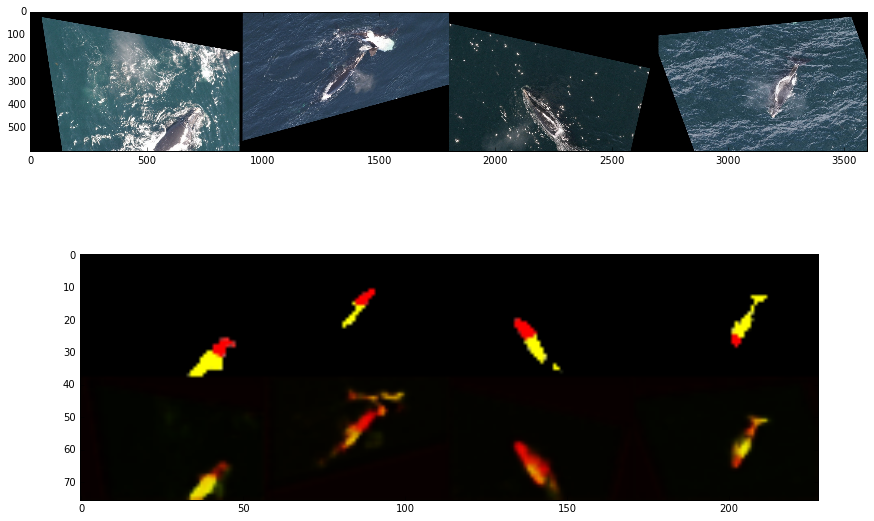

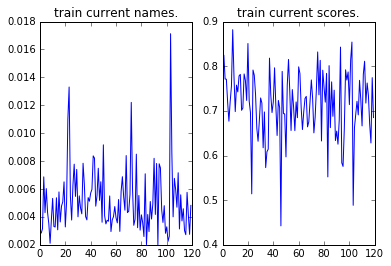

****************************************************************************************************


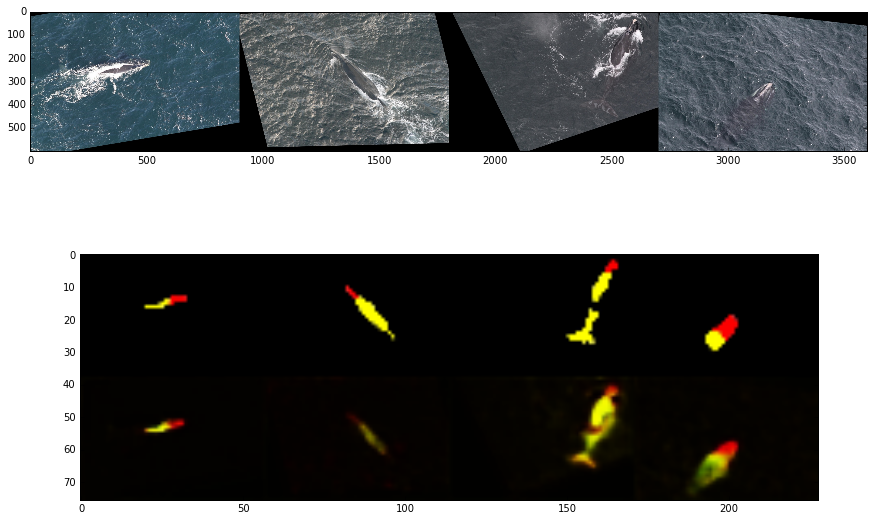

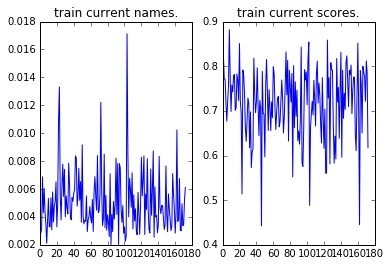

****************************************************************************************************


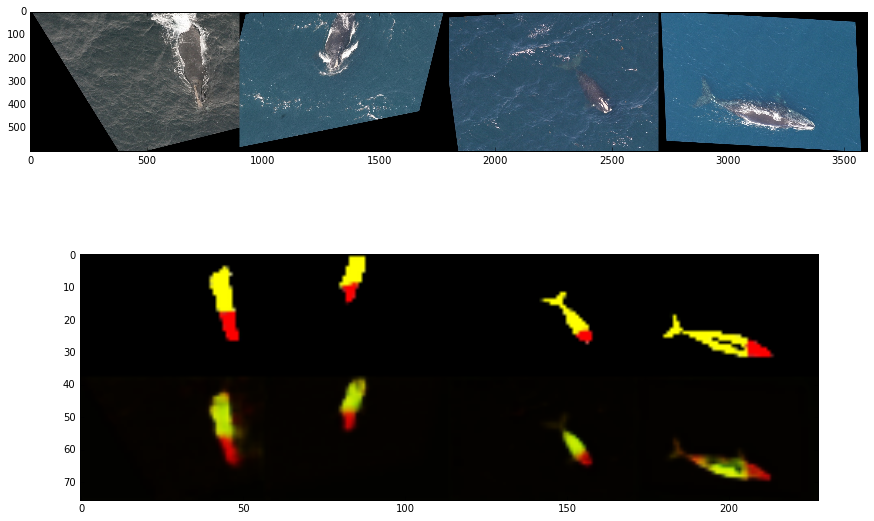

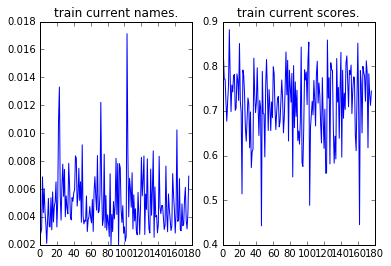

****************************************************************************************************


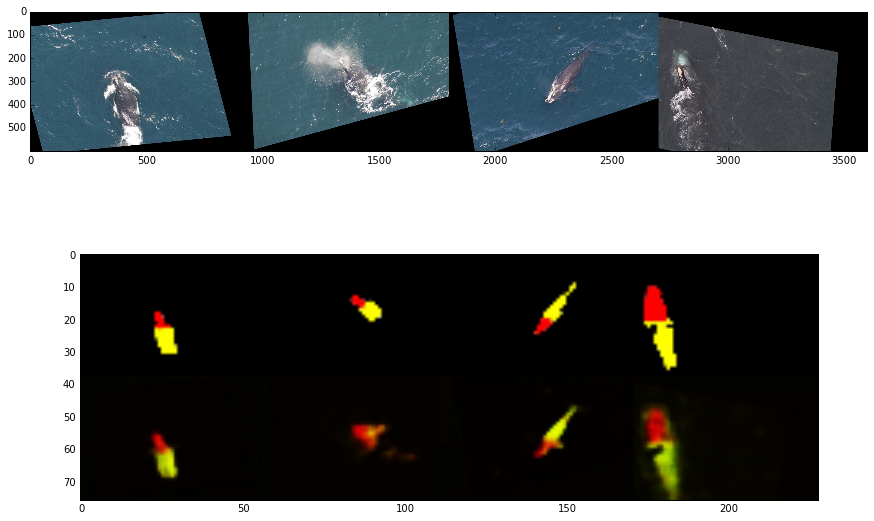

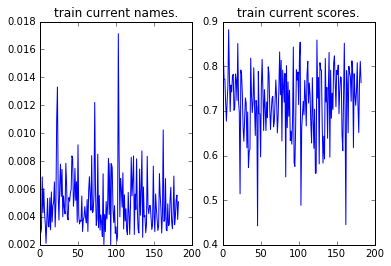

In [ ]:
if __name__ == "__main__":

        import matplotlib.pyplot as plt

        displayProb = 0.05
        learningRate = 0.01
        load = 1
        save = 0
        diceThreshold = 0.5
        nEpochs = 1
        batchSize = 4
        trPaths = glob.glob("../augmented/train/x_*")
        tePaths = glob.glob("../augmented/test/x_*")
        modelName = "model.tf"
       
        x, y, yPred = model.main()

        loss = mse(yPred,y)
        diceScore, _ = dice(yPred,y,diceThreshold)
        lr = tf.placeholder(tf.float32)
        train = trainer(loss,lr)

        saver = tf.train.Saver()
        
        trPerformance = performance("train")
        tePerformance = performance("test")
        with tf.Session() as sess:
            if load == 1: 
                saver.restore(sess,modelName)
            else:
                init = tf.initialize_all_variables()
                sess.run(init)
            

            for epoch in range(nEpochs):
                
                finTr = finTe = 0
                print("EPOCH {0} of {1}".format(epoch,nEpochs))
                print(learningRate)
                trFeed = loadData.feed(inDims = [batchSize,600,900,3], outDims = [batchSize,38,57,3], paths = trPaths)
                teFeed = loadData.feed(inDims = [batchSize,600,900,3], outDims = [batchSize,38,57,3], paths = tePaths)

                while finTr == 0:
                    X,Y,finTr = trFeed.next()
                    _, loss_, diceScore_, yPred_ = sess.run([train,loss,diceScore,yPred], feed_dict = {x:X,y:Y,lr:learningRate})
                    trPerformance.add(loss_,diceScore_)
                    if np.random.uniform() < displayProb:
                        showBatch(X,Y,yPred_,unnormalize=1)
                        trPerformance.displayCurrentPerformance()
               
                while finTe == 0:
                    X,Y,finTe = teFeed.next()
                    loss_, diceScore_, yPred_ = sess.run([loss,diceScore,yPred], feed_dict = {x:X,y:Y})
                    tePerformance.add(loss_,diceScore_)
                    if np.random.uniform() < displayProb:
                        showBatch(X,Y,yPred_,unnormalize=1)
                        tePerformance.displayCurrentPerformance()
                        
                clear_output()
                
                trPerformance.endEpoch()
                tePerformance.endEpoch()

                trPerformance.displayEpochPerformance()
                tePerformance.displayEpochPerformance()
                
                if epoch % 2 == 0 or epoch == nEpochs-1:
                    if epoch > 0:
                        learningRate/= 1.5
                        print("Dropped learning rate to {0:.6f}".format(learningRate))
                    if save == 1:
                        print("Saving")
                        save_path = saver.save(sess, modelName)
